<a href="https://colab.research.google.com/github/SerigneSaliouDia/Projet-Deep-learnig/blob/main/Diarnou%26Saliou_ProjetReconnaissanceFaciale_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet Deep Learning : Reconnaissance Faciale avec MLP**
<center>
<img src="https://www.99techpost.com/wp-content/uploads/2023/08/Deep-Learning-Face-Recognition.jpg" width="500"/>
</center>

## **Présenté par:**
* Serigne Saliou Dia
* Diarnou Faye

## **1. Introduction:**
Ce projet a pour objectif de concevoir un modèle de reconnaissance faciale
en utilisant uniquement un Perceptron Multicouche (MLP), sans CNN.
Nous travaillerons sur le prétraitement des données, la régularisation,
l'augmentation des données et l'interprétation des résultats.

La reconnaissance faciale est utilisée dans de nombreux domaines :
- Sécurité et contrôle d'accès
- Déverrouillage des appareils mobiles
- Identification dans les réseaux sociaux
- Applications dans la santé et la surveillance

Dans ce projet, nous allons utiliser le dataset Olivetti Faces pour entraîner notre modèle MLP.

## **Importation des bibliothèques**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import copy
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')



## **Configuration initiale**

In [ ]:
# Vérification de la disponibilité du GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

Utilisation de: cpu


# 2. **Chargement et affichage des données**

### Chargement du dataset

Pour ce projet, on utilise le dataset **Olivetti Faces**, fourni par `sklearn.datasets`. Il contient :

- **400 images** de **40 personnes**, avec **10 images par personne**
- Chaque image est en **niveaux de gris**, de taille **64 × 64 pixels**

Chargement du dataset Olivetti Faces...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Dimensions des données: (400, 4096)
Nombre de classes (personnes): 40
Distribution des classes: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
Visualisation de quelques exemples:


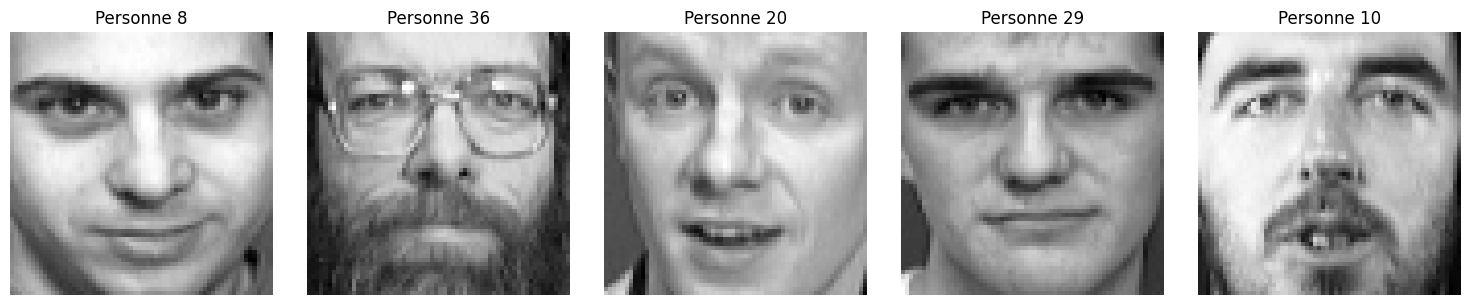


Visualisation de plusieurs images d'une même personne:


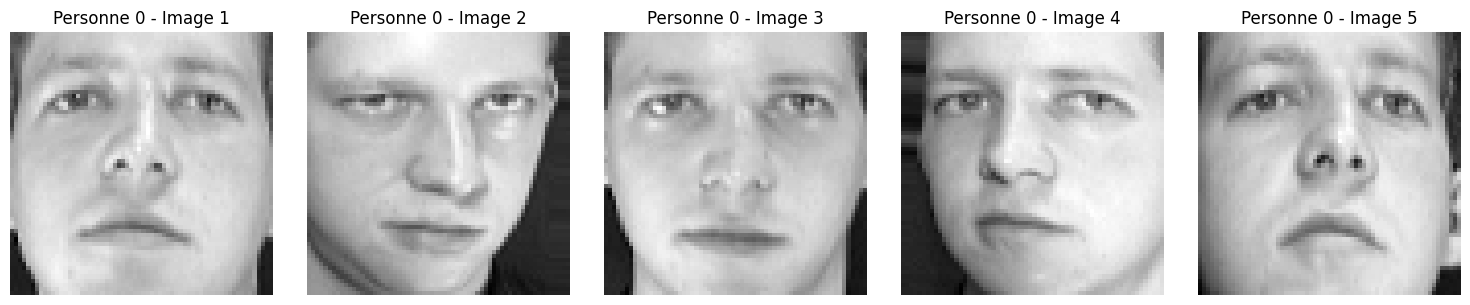

In [ ]:
# Chargement du dataset Olivetti Faces
print("Chargement du dataset Olivetti Faces...")
faces = fetch_olivetti_faces()
X, y = faces.data, faces.target

# Afficher quelques informations sur le dataset
print(f"Dimensions des données: {X.shape}")
print(f"Nombre de classes (personnes): {len(np.unique(y))}")
print(f"Distribution des classes: {np.bincount(y)}")

# Visualisation de quelques visages
def show_faces(X, y, n_faces=5):
    fig, axes = plt.subplots(1, n_faces, figsize=(15, 3))
    for i in range(n_faces):
        idx = np.random.randint(0, X.shape[0])
        axes[i].imshow(X[idx].reshape(64, 64), cmap='gray')
        axes[i].set_title(f'Personne {y[idx]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Visualisation de quelques exemples:")
show_faces(X, y)

# Visualisons quelques images de la même personne
def show_same_person(X, y, person_id=0, n_faces=5):
    # Trouver les indices des images de la personne spécifiée
    indices = np.where(y == person_id)[0]

    # Sélectionner aléatoirement n_faces images ou toutes si moins disponibles
    if len(indices) < n_faces:
        selected_indices = indices
    else:
        selected_indices = np.random.choice(indices, n_faces, replace=False)

    fig, axes = plt.subplots(1, len(selected_indices), figsize=(15, 3))

    # Si une seule image est sélectionnée, axes n'est pas un tableau
    if len(selected_indices) == 1:
        axes = [axes]

    for i, idx in enumerate(selected_indices):
        axes[i].imshow(X[idx].reshape(64, 64), cmap='gray')
        axes[i].set_title(f'Personne {y[idx]} - Image {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualisation de plusieurs images d'une même personne:")
show_same_person(X, y, person_id=0)

# 3. **Prétraitement des données**

L’objectif ici est de **préparer les données pour un MLP**, en suivant les exigences spécifiques : redimensionnement, aplatissage, normalisation et encodage des étiquettes. Cette étape est cruciale pour assurer un apprentissage efficace par un Perceptron Multicouche.

---

### Redimensionnement et aplatissage

Les images du dataset Olivetti Faces sont déjà de taille `64x64`. Cependant, comme un **MLP ne peut traiter que des vecteurs**, il est nécessaire de transformer chaque image 2D en un **vecteur plat** :



Valeur moyenne des pixels: 0.5470
Écart-type des pixels: 0.1725
Nombre d'images d'entraînement: 280
Nombre d'images de test: 120

Visualisation d'une image après normalisation:


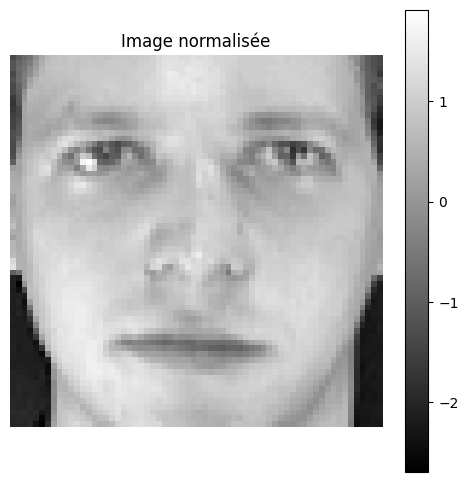

Valeurs min/max après normalisation: -2.6919 / 1.9070
Moyenne/écart-type après normalisation: 0.5206 / 0.8660


In [ ]:
# Calcul des statistiques pour une meilleure normalisation
X_mean = X.mean()
X_std = X.std()
print(f"Valeur moyenne des pixels: {X_mean:.4f}")
print(f"Écart-type des pixels: {X_std:.4f}")

# Conversion des données en tensors PyTorch avec normalisation
X_tensor = torch.tensor((X - X_mean) / X_std, dtype=torch.float32).reshape(-1, 1, 64, 64)
# Expansion à 3 canaux pour compatibilité avec les architectures standards et transformation
X_tensor = X_tensor.repeat(1, 3, 1, 1)
y_tensor = torch.tensor(y, dtype=torch.long)

# Création du dataset PyTorch
dataset = TensorDataset(X_tensor, y_tensor)

# Split train/test (70/30)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                          generator=torch.Generator().manual_seed(42))

print(f"Nombre d'images d'entraînement: {len(train_dataset)}")
print(f"Nombre d'images de test: {len(test_dataset)}")

# Visualisation d'une image normalisée
def show_normalized_image(X_tensor, idx=0):
    # Prend le premier canal (car les 3 canaux sont identiques)
    img = X_tensor[idx, 0].numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title('Image normalisée')
    plt.colorbar()
    plt.axis('off')
    plt.show()

    # Afficher les stats de l'image normalisée
    print(f"Valeurs min/max après normalisation: {img.min():.4f} / {img.max():.4f}")
    print(f"Moyenne/écart-type après normalisation: {img.mean():.4f} / {img.std():.4f}")

print("\nVisualisation d'une image après normalisation:")
show_normalized_image(X_tensor)

# **4. Augmentation de données**

L’augmentation de données est une technique essentielle pour améliorer la **généralisation du modèle** en créant artificiellement de la diversité dans les données d’entraînement. Elle permet au modèle de devenir plus robuste à des variations telles que l’orientation, la luminosité, etc.

---

### Définition des transformations

On utilise ici `torchvision.transforms` pour appliquer une série de transformations réalistes :



Visualisation des augmentations de données:


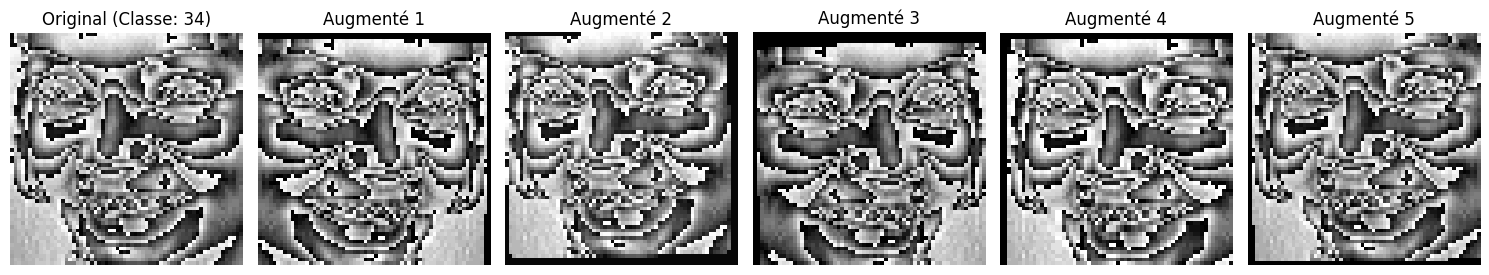

In [ ]:
# Création des transformations pour l'augmentation de données
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, scale=(0.95, 1.05), translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

# Classe pour appliquer l'augmentation de données au dataset
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]
        if self.transform:
            # Appliquer les transformations
            img = self.transform(img)
        return img, label

# Créer un dataset augmenté pour l'entraînement
augmented_train_dataset = AugmentedDataset(train_dataset, transform_train)

# Visualiser l'effet de l'augmentation de données
def visualize_augmentations(dataset, idx=0, num_augmented=5):
    img, label = dataset[idx]
    orig_img = transforms.ToPILImage()(img) if isinstance(img, torch.Tensor) else img

    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_augmented+1, 1)
    plt.imshow(transforms.ToPILImage()(orig_img) if not isinstance(orig_img, Image.Image) else orig_img)
    plt.title(f"Original (Classe: {label})")
    plt.axis('off')

    augmented_dataset = AugmentedDataset(dataset, transform_train)
    for i in range(num_augmented):
        aug_img, _ = augmented_dataset[idx]
        plt.subplot(1, num_augmented+1, i+2)
        plt.imshow(transforms.ToPILImage()(aug_img))
        plt.title(f"Augmenté {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualisation des augmentations de données:")
visualize_augmentations(train_dataset)

# **5. Construction du modèle MLP**

###  Pourquoi un MLP ?

Le **Perceptron Multicouche (MLP)** est un modèle dense (fully connected) qui peut apprendre des représentations complexes. Contrairement aux **CNN**, il ne prend pas directement en compte la structure spatiale des images. C’est pourquoi nous devons :

- **Aplatir** les images (`64 × 64 × 3`) en vecteurs (`12288`)
- Ajouter des **couches cachées denses** pour la profondeur
- Utiliser la **fonction d’activation ReLU**
- Ajouter du **Dropout** pour la régularisation
- En sortie : une couche avec `Softmax` implicite via `CrossEntropyLoss`


In [ ]:
# Modèle MLP de base
class FaceMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.5):
        super(FaceMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


print("Architecture du modèle MLP:")
print(FaceMLP(64 * 64 * 3, 512, 256, len(np.unique(y))))



Architecture du modèle MLP:
FaceMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=40, bias=True)
)


# **6. Entraînement du modèle**

###  Objectif
L'objectif de cette phase est de former notre modèle `FaceMLP` sur les données d'entraînement tout en suivant l'évolution de la **perte** et de l'**accuracy** à chaque époque. Nous avons également intégré une stratégie d'**early stopping** pour éviter le surapprentissage.

---

###  Fonction d'entraînement

La fonction `train_model` s'occupe de l'entraînement du modèle sur un certain nombre d'époques, avec les éléments suivants :

1. **Phase d'entraînement** :
    - Le modèle est mis en mode `train`.
    - Pour chaque mini-lot d'images dans le `train_loader`, les gradients sont calculés et l'optimisation est effectuée.
    - La perte et l'accuracy sont calculées et enregistrées.

2. **Phase de validation** :
    - Le modèle est mis en mode `eval`.
    - Aucune mise à jour des poids n'est effectuée pendant cette phase (utilisation de `torch.no_grad()`).
    - Les résultats sont comparés avec les labels réels pour obtenir la perte et l'accuracy sur les données de validation.

3. **Early Stopping** :
    - Si aucune amélioration de la **perte** ou de **l'accuracy** sur les données de validation n'est observée pendant un certain nombre d'époques consécutives, l'entraînement est arrêté pour éviter le surapprentissage.
    - Le modèle avec la meilleure performance de validation est sauvegardé.

---

###  Visualisation des performances

La fonction renvoie les **historique des pertes** et **accuracies** pour l'entraînement et la validation à chaque époque. Ces informations peuvent être utilisées pour tracer des courbes et évaluer le comportement du modèle.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, early_stopping_patience=5):
    """
    Entraîne le modèle et renvoie les historiques de pertes et d'accuracy.
    Intègre également l'early stopping pour éviter le surapprentissage.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Pour early stopping
    no_improve_epochs = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # ====== PHASE D'ENTRAÎNEMENT ======
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        # Barre de progression
        train_pbar = tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in train_pbar:
            # Préparer les données
            inputs = inputs.view(inputs.size(0), -1).to(device)  # Aplatir pour MLP
            labels = labels.to(device)

            # Réinitialiser les gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # Backward pass et optimisation
                loss.backward()
                optimizer.step()

            # Statistiques
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_train += labels.size(0)

            # Mise à jour de la barre de progression
            train_pbar.set_postfix({'loss': loss.item(), 'acc': torch.sum(preds == labels.data).item() / labels.size(0)})

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = running_corrects / total_train * 100
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2f}%')

        # ====== PHASE DE VALIDATION ======
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_val = 0

        # Barre de progression pour validation
        val_pbar = tqdm(val_loader, desc=f'Val Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in val_pbar:
            # Préparer les données
            inputs = inputs.view(inputs.size(0), -1).to(device)  # Aplatir pour MLP
            labels = labels.to(device)

            # Forward pass (sans calcul de gradient)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            # Statistiques
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_val += labels.size(0)

            # Mise à jour de la barre de progression
            val_pbar.set_postfix({'loss': loss.item(), 'acc': torch.sum(preds == labels.data).item() / labels.size(0)})

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = running_corrects / total_val * 100
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.2f}%')

        # Sauvegarde du meilleur modèle
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0  # Réinitialisation du compteur
        else:
            no_improve_epochs += 1

        # Early stopping
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping à l\'epoch {epoch+1}')
            break

        print()

    print(f'Meilleure accuracy de validation: {best_acc:.2f}%')

    # Charger les meilleurs poids
    model.load_state_dict(best_model_wts)

    return train_losses, train_accs, val_losses, val_accs, best_acc


### Étapes clés:

#### Définition des dimensions du modèle:

Le modèle FaceMLP est conçu pour accepter des images de taille 64x64 avec 3 canaux (RGB), soit un total de 64 × 64 × 3 = 12 288 caractéristiques en entrée.

#### Le modèle comporte deux couches cachées :

- La première avec 512 neurones

- La seconde avec 256 neurones

- Un dropout de 0.5 est appliqué pour réduire le risque de surapprentissage (overfitting).

#### Création des dataloaders:

Les dataloaders train_loader et test_loader permettent de charger les données par mini-lots de taille 32.
Cela facilite l’entraînement du modèle en traitant les données par petits groupes, ce qui optimise l’efficacité du processus.

### Entraînement du modèle:

#### Le modèle FaceMLP est :

- Initialisé

- Déplacé vers l’appareil de calcul (device)

#### Ensuite, on utilise :

- L’optimiseur Adam avec un taux d’apprentissage de 0.001

- La fonction de perte CrossEntropyLoss

- La fonction train_model entraîne le modèle pendant 25 époques, avec une stratégie de early stopping si nécessaire.

### Visualisation des courbes d'apprentissage

#### À la fin de l'entraînement :

Les courbes de perte (loss) et d’accuracy pour les phases d’entraînement et de validation sont affichées.

#### Cela permet :

- D’évaluer les performances du modèle

- D’identifier d’éventuels problèmes comme le surapprentissage ou une sous-performance.



FaceMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=40, bias=True)
)
Epoch 1/25
----------


Train Epoch 1/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 4.3138 Acc: 5.00%


Val Epoch 1/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 3.4077 Acc: 15.00%

Epoch 2/25
----------


Train Epoch 2/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 3.4703 Acc: 17.50%


Val Epoch 2/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 2.7081 Acc: 25.00%

Epoch 3/25
----------


Train Epoch 3/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 2.7267 Acc: 33.21%


Val Epoch 3/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 2.4152 Acc: 44.17%

Epoch 4/25
----------


Train Epoch 4/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 2.2273 Acc: 39.64%


Val Epoch 4/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 2.2668 Acc: 40.83%

Epoch 5/25
----------


Train Epoch 5/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.7902 Acc: 50.71%


Val Epoch 5/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.8687 Acc: 56.67%

Epoch 6/25
----------


Train Epoch 6/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.5513 Acc: 58.93%


Val Epoch 6/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.5069 Acc: 66.67%

Epoch 7/25
----------


Train Epoch 7/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.3975 Acc: 61.79%


Val Epoch 7/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.4172 Acc: 64.17%

Epoch 8/25
----------


Train Epoch 8/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.0764 Acc: 70.00%


Val Epoch 8/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.3605 Acc: 68.33%

Epoch 9/25
----------


Train Epoch 9/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9244 Acc: 72.50%


Val Epoch 9/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.1090 Acc: 80.83%

Epoch 10/25
----------


Train Epoch 10/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.8931 Acc: 71.07%


Val Epoch 10/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.0741 Acc: 77.50%

Epoch 11/25
----------


Train Epoch 11/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5935 Acc: 80.71%


Val Epoch 11/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.9731 Acc: 79.17%

Epoch 12/25
----------


Train Epoch 12/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4910 Acc: 86.07%


Val Epoch 12/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.0188 Acc: 78.33%

Epoch 13/25
----------


Train Epoch 13/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6115 Acc: 83.21%


Val Epoch 13/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.8611 Acc: 83.33%

Epoch 14/25
----------


Train Epoch 14/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4705 Acc: 88.21%


Val Epoch 14/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.8419 Acc: 82.50%

Epoch 15/25
----------


Train Epoch 15/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4594 Acc: 86.79%


Val Epoch 15/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.9225 Acc: 81.67%

Epoch 16/25
----------


Train Epoch 16/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4297 Acc: 87.14%


Val Epoch 16/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.8539 Acc: 81.67%

Epoch 17/25
----------


Train Epoch 17/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4315 Acc: 85.71%


Val Epoch 17/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.7652 Acc: 86.67%

Epoch 18/25
----------


Train Epoch 18/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3993 Acc: 86.07%


Val Epoch 18/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.7919 Acc: 85.83%

Epoch 19/25
----------


Train Epoch 19/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3476 Acc: 90.00%


Val Epoch 19/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.8617 Acc: 80.83%

Epoch 20/25
----------


Train Epoch 20/25:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3771 Acc: 88.57%


Val Epoch 20/25:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.7735 Acc: 83.33%
Early stopping à l'epoch 20
Meilleure accuracy de validation: 86.67%


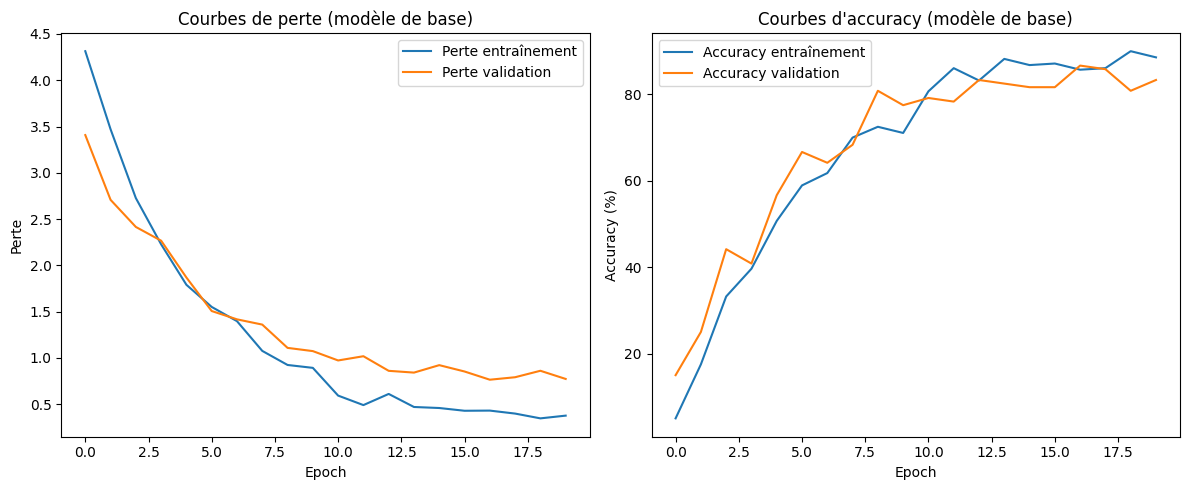

In [ ]:
# Définition des dimensions pour le modèle de base
input_size = 64 * 64 * 3  # Images 64x64 avec 3 canaux
hidden_size1 = 512
hidden_size2 = 256
num_classes = len(np.unique(y))
dropout_rate = 0.5

# Créer les dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Créer le modèle de base
baseline_model = FaceMLP(input_size, hidden_size1, hidden_size2, num_classes, dropout_rate)
baseline_model.to(device)
print(baseline_model)

# Entraîner le modèle de base
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

train_losses, train_accs, val_losses, val_accs, _ = train_model(
baseline_model, train_loader, test_loader, criterion, optimizer, num_epochs=25
)

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Perte entraînement')
plt.plot(val_losses, label='Perte validation')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()
plt.title('Courbes de perte (modèle de base)')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Accuracy entraînement')
plt.plot(val_accs, label='Accuracy validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Courbes d\'accuracy (modèle de base)')
plt.tight_layout()
plt.show()

### **Courbes de perte (à gauche)**
Observation générale :

Les deux courbes de perte (train & validation) diminuent clairement → signe d’un apprentissage efficace.

La perte d'entraînement descend bien en dessous de 0.5 à la fin.

La perte de validation stagne un peu à partir de l’époque 10–12.

Interprétation :

Jusqu’à ~époque 10, les deux courbes diminuent de façon synchrone → bon entraînement sans surapprentissage au début.

Après l’époque 10, la perte validation cesse de descendre autant que la perte d’entraînement → soupçon d’overfitting léger.

### **Courbes d’accuracy (à droite)**
Observation générale :

L’accuracy d'entraînement augmente progressivement jusqu’à ~90%.

L’accuracy de validation suit une trajectoire similaire, plafonnant à ~85–88%.

Interprétation :

Bonne capacité de généralisation : la courbe de validation reste proche de celle de l'entraînement.

L’écart qui se creuse à partir de l’époque 12 environ peut indiquer un début de surapprentissage, mais rien de dramatique.

# **7. Évaluation de notre modéle**

### Évaluation du modèle
La fonction evaluate_model permet d’évaluer la performance du modèle sur l’ensemble de test. Elle affiche :

- L’accuracy

- La matrice de confusion

- Le rapport de classification

- Une analyse des erreurs

- Ainsi que des exemples mal classés pour visualiser les erreurs.

### a. Calcul de l'Accuracy:

L’accuracy est calculée en comparant les prédictions du modèle avec les étiquettes réelles (labels).

- correct : nombre de prédictions correctes

- total : nombre total d’exemples dans le jeu de test

- L’accuracy est alors :
accuracy = (correct / total) × 100

### b. Matrice de confusion
Une matrice de confusion est affichée à l’aide d’un heatmap (carte thermique) avec Seaborn.

Elle permet d’identifier quelles classes sont les plus souvent confondues par le modèle.

C’est un excellent outil pour analyser la répartition des erreurs de classification.

### c. Rapport de classification
Le classification_report de Scikit-learn fournit :

- Précision (precision)

- Rappel (recall)

- Score F1
…pour chaque classe individuellement.

Cela donne une vue plus fine des performances du modèle que l’accuracy globale seule.

### d. Analyse des erreurs
Cette analyse :

- Identifie les cas où la prédiction est incorrecte

- Affiche les erreurs les plus fréquentes

Cela t’aide à comprendre où et pourquoi le modèle fait des erreurs.

### e. Visualisation des exemples mal classés
La fonction visualize_misclassifications permet de :

- Afficher quelques images mal classées

- Visualiser les types d’images ou de classes problématiques

- Déceler des caractéristiques spécifiques difficiles à prédire

- C’est une étape clé pour améliorer le modèle.

Évaluation du modèle sur l'ensemble de test...
Accuracy sur l'ensemble de test: 86.67%


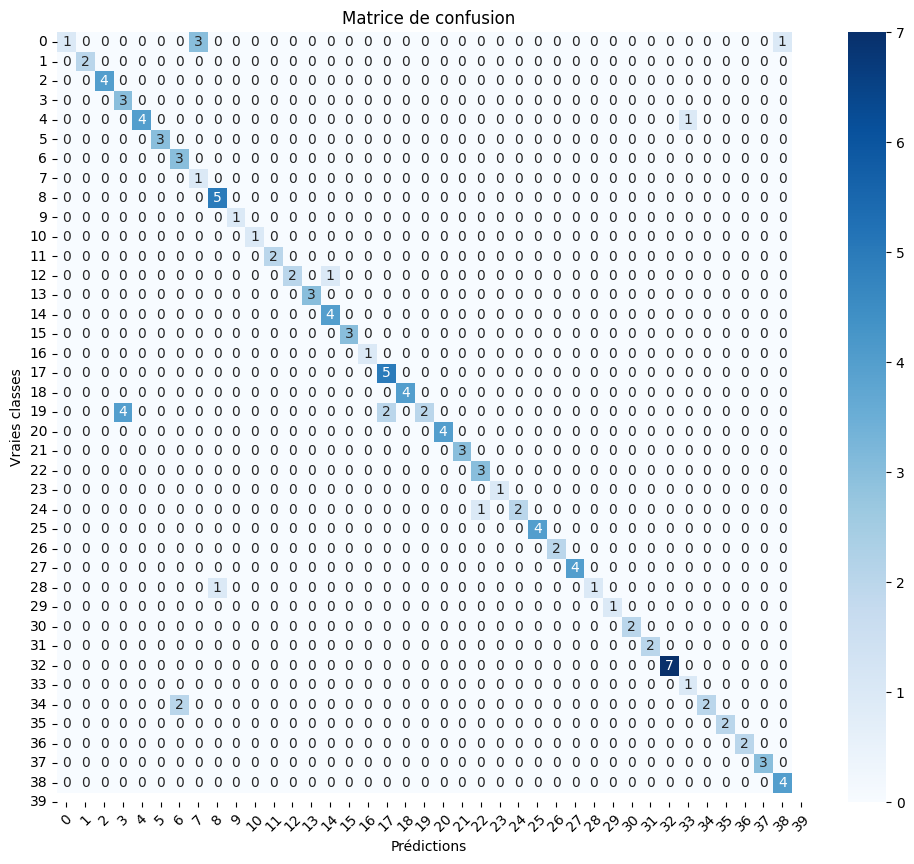


Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       0.43      1.00      0.60         3
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         3
           6       0.60      1.00      0.75         3
           7       0.25      1.00      0.40         1
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       0.80      1.00      0.89         4
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         1

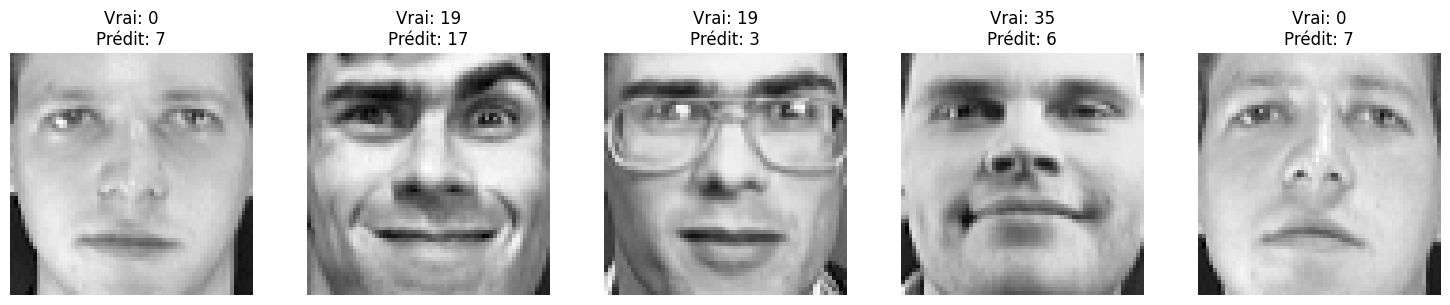

In [ ]:
from sklearn.metrics import classification_report # Import the classification_report function

def evaluate_model(model, test_loader, num_classes, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten les images pour le MLP
            images = images.view(images.size(0), -1)  # Transforme [batch, 3, 64, 64] en [batch, 64*64*3]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy sur l\'ensemble de test: {accuracy:.2f}%')

    # Matrice de confusion
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies classes')
    plt.title('Matrice de confusion')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    # Rapport de classification
    print("\nRapport de classification:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Analyse des erreurs
    error_analysis = {}
    for true_label, pred_label in zip(all_labels, all_preds):
        if true_label != pred_label:
            true_name = class_names[true_label] if class_names else true_label
            pred_name = class_names[pred_label] if class_names else pred_label
            error_key = f"Vrai: {true_name}, Prédit: {pred_name}"
            error_analysis[error_key] = error_analysis.get(error_key, 0) + 1

    # Afficher les erreurs les plus fréquentes
    if error_analysis:
        print("\nAnalyse des erreurs les plus fréquentes:")
        for error, count in sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"{error}: {count} occurrences")
    else:
        print("\nAucune erreur de classification!")

    # Visualiser quelques exemples mal classés
    visualize_misclassifications(model, test_loader, class_names)

    return accuracy, conf_matrix

def visualize_misclassifications(model, test_loader, class_names=None, num_examples=5):
    model.eval()
    misclassified_examples = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten les images pour le MLP
            images_flat = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            outputs = model(images_flat)
            _, predicted = torch.max(outputs.data, 1)

            # Trouver les exemples mal classés
            misclassified_mask = (predicted != labels)
            if misclassified_mask.sum() > 0:
                misclassified_indices = torch.where(misclassified_mask)[0]
                for idx in misclassified_indices:
                    misclassified_examples.append({
                        'image': images[idx].cpu(),
                        'true': labels[idx].item(),
                        'pred': predicted[idx].item()
                    })
                    if len(misclassified_examples) >= num_examples:
                        break

            if len(misclassified_examples) >= num_examples:
                break

    # Afficher les exemples mal classés
    if misclassified_examples:
        plt.figure(figsize=(15, 3))
        for i, example in enumerate(misclassified_examples[:num_examples]):
            plt.subplot(1, num_examples, i + 1)
            # Convertir l'image tensor (C,H,W) en format PIL
            img = example['image'].permute(1, 2, 0).numpy()  # Convertir de (C,H,W) à (H,W,C)
            img = (img - img.min()) / (img.max() - img.min())  # Normaliser

            true_label = class_names[example['true']] if class_names else example['true']
            pred_label = class_names[example['pred']] if class_names else example['pred']

            plt.imshow(img)
            plt.title(f"Vrai: {true_label}\nPrédit: {pred_label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Aucun exemple mal classé trouvé.")

# Utilisation
print("Évaluation du modèle sur l'ensemble de test...")
# Supposons que vous avez une liste de noms de classes
# class_names = ["classe1", "classe2", ...]
accuracy, conf_matrix = evaluate_model(baseline_model, test_loader, num_classes, class_names=None)

# 8. Optimisation des hyperparamètres

In [ ]:
!pip install optuna

In [ ]:
import optuna
def objective(trial):
    # Hyperparamètres à optimiser
    hidden_size1 = trial.suggest_int("hidden_size1", 128, 1024, step=128)
    hidden_size2 = trial.suggest_int("hidden_size2", 64, hidden_size1, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Instanciation du modèle
    input_size = 64 * 64 * 3  # Images 64x64 avec 3 canaux
    num_classes = len(np.unique(y))
    model = FaceMLP(input_size, hidden_size1, hidden_size2, num_classes, dropout_rate).to(device)

    # Optimiseur et fonction de coût
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Entraînement (rapide, 5 époques)
    for epoch in range(5):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Aplatir les images pour le MLP
            X_batch = X_batch.view(X_batch.size(0), -1)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:  # Assurez-vous que val_loader est défini
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Aplatir les images pour le MLP
            X_batch = X_batch.view(X_batch.size(0), -1)

            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    return 1.0 - accuracy  # On minimise l’erreur (1 - accuracy)




In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Meilleur score : {:.4f}".format(1.0 - study.best_value))
print("Hyperparamètres optimaux :")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")



[I 2025-04-23 04:35:16,003] A new study created in memory with name: no-name-aa6b1e72-6f31-4a47-bb3f-bf5701cfe4df
[I 2025-04-23 04:35:18,059] Trial 0 finished with value: 0.4 and parameters: {'hidden_size1': 384, 'hidden_size2': 256, 'dropout_rate': 0.10533565411131965, 'learning_rate': 0.0064632574474886625}. Best is trial 0 with value: 0.4.
[I 2025-04-23 04:35:18,743] Trial 1 finished with value: 0.5083333333333333 and parameters: {'hidden_size1': 128, 'hidden_size2': 64, 'dropout_rate': 0.21561609523730554, 'learning_rate': 0.00385444090107701}. Best is trial 0 with value: 0.4.
[I 2025-04-23 04:35:20,054] Trial 2 finished with value: 0.5416666666666667 and parameters: {'hidden_size1': 256, 'hidden_size2': 192, 'dropout_rate': 0.4907304015979893, 'learning_rate': 0.000412457344941678}. Best is trial 0 with value: 0.4.
[I 2025-04-23 04:35:23,082] Trial 3 finished with value: 0.15000000000000002 and parameters: {'hidden_size1': 512, 'hidden_size2': 256, 'dropout_rate': 0.25108989750235

Meilleur score : 0.8500
Hyperparamètres optimaux :
  hidden_size1: 512
  hidden_size2: 256
  dropout_rate: 0.25108989750235533
  learning_rate: 0.00047825520592762583


# 9. Nouveau Modèle avec les hyperparamètres:
Après avoir trouvé les meilleurs hyperparamètres via Optuna, on crée et entraîne le modèle final.

## Hyperparamètres optimisés

Nous utilisons les meilleurs hyperparamètres trouvés par Optuna pour construire le modèle final :

`hidden_size1` : le nombre de neurones dans la première couche cachée.

`hidden_size2` : le nombre de neurones dans la deuxième couche cachée.

`dropout_rate` : taux de régularisation.

`learning_rate` : taux d’apprentissage de l’optimiseur.

## Entraînement du modèle final

Le modèle final est entraîné pendant `20 epochs` pour obtenir une performance maximale avec les hyperparamètres optimaux.

# Visualisation des courbes d’apprentissage

Les courbes d’apprentissage `(perte et accuracy)` du modèle final sont affichées pour voir l’évolution de la performance durant l’entraînement et la validation.

Entraînement du modèle final avec les meilleurs hyperparamètres...
Epoch 1/20
----------


Train Epoch 1/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 3.4836 Acc: 14.64%


Val Epoch 1/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 2.7334 Acc: 21.67%

Epoch 2/20
----------


Train Epoch 2/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 2.1506 Acc: 39.64%


Val Epoch 2/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 2.0927 Acc: 49.17%

Epoch 3/20
----------


Train Epoch 3/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.3277 Acc: 62.14%


Val Epoch 3/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.3938 Acc: 63.33%

Epoch 4/20
----------


Train Epoch 4/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.8179 Acc: 76.43%


Val Epoch 4/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 1.0981 Acc: 73.33%

Epoch 5/20
----------


Train Epoch 5/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4856 Acc: 86.43%


Val Epoch 5/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.8750 Acc: 78.33%

Epoch 6/20
----------


Train Epoch 6/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3551 Acc: 91.07%


Val Epoch 6/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.8130 Acc: 82.50%

Epoch 7/20
----------


Train Epoch 7/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2585 Acc: 93.93%


Val Epoch 7/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5942 Acc: 84.17%

Epoch 8/20
----------


Train Epoch 8/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1403 Acc: 97.14%


Val Epoch 8/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5186 Acc: 84.17%

Epoch 9/20
----------


Train Epoch 9/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0758 Acc: 98.93%


Val Epoch 9/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.6208 Acc: 83.33%

Epoch 10/20
----------


Train Epoch 10/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0849 Acc: 97.50%


Val Epoch 10/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.6421 Acc: 85.83%

Epoch 11/20
----------


Train Epoch 11/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0752 Acc: 97.86%


Val Epoch 11/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5553 Acc: 85.83%

Epoch 12/20
----------


Train Epoch 12/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0499 Acc: 99.64%


Val Epoch 12/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5037 Acc: 86.67%

Epoch 13/20
----------


Train Epoch 13/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0535 Acc: 98.93%


Val Epoch 13/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5069 Acc: 87.50%

Epoch 14/20
----------


Train Epoch 14/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0344 Acc: 99.64%


Val Epoch 14/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5366 Acc: 86.67%

Epoch 15/20
----------


Train Epoch 15/20:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0294 Acc: 99.64%


Val Epoch 15/20:   0%|          | 0/4 [00:00<?, ?it/s]

Val Loss: 0.5798 Acc: 85.83%
Early stopping à l'epoch 15
Meilleure accuracy de validation: 87.50%


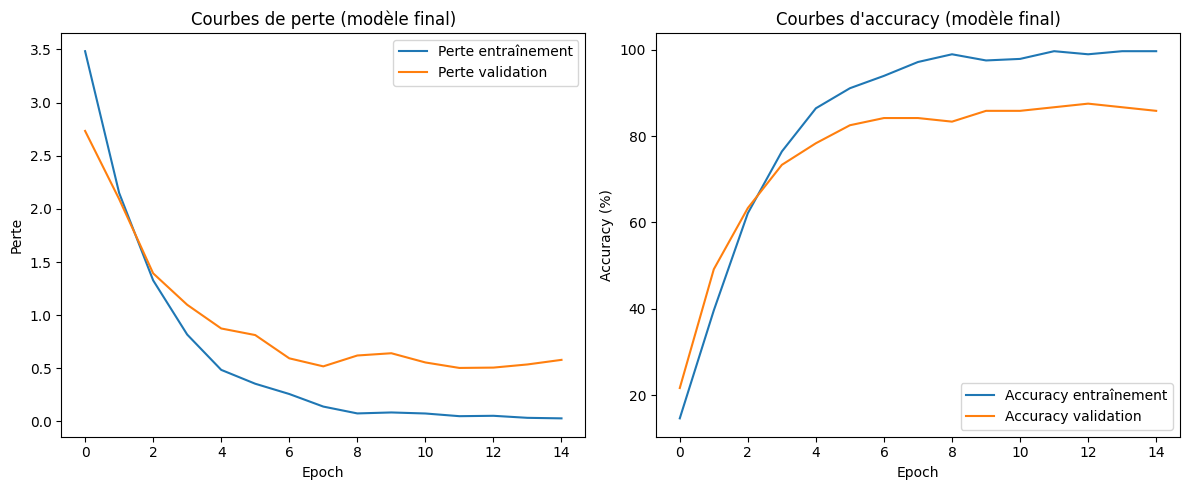

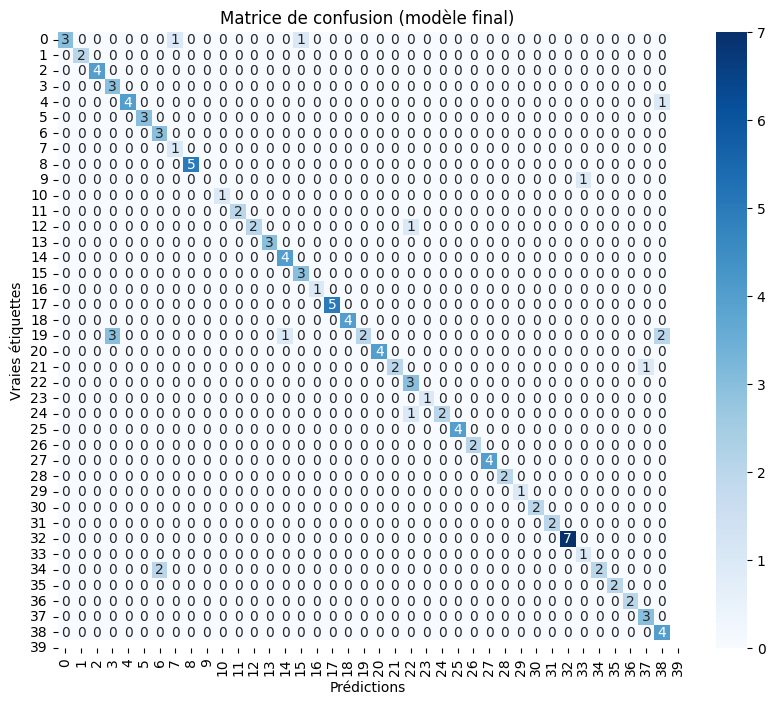

Modèle final sauvegardé sous 'face_recognition_mlp_final.pth'


In [ ]:
# Création et entraînement du modèle final avec les meilleurs hyperparamètres
best_hidden_size1 = study.best_params['hidden_size1']
best_hidden_size2 = study.best_params['hidden_size2']
best_dropout_rate = study.best_params['dropout_rate']
best_learning_rate = study.best_params['learning_rate']

final_model = FaceMLP(input_size, best_hidden_size1, best_hidden_size2, num_classes, best_dropout_rate)
final_model.to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate)

print("Entraînement du modèle final avec les meilleurs hyperparamètres...")
train_losses, train_accs, val_losses, val_accs, _ = train_model(
    final_model, train_loader, test_loader, criterion, final_optimizer, num_epochs=20
)
# Visualisation des courbes d'apprentissage finales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Perte entraînement')
plt.plot(val_losses, label='Perte validation')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()
plt.title('Courbes de perte (modèle final)')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Accuracy entraînement')
plt.plot(val_accs, label='Accuracy validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Courbes d\'accuracy (modèle final)')

plt.tight_layout()
plt.show()

# Evaluation du modèle final et stockage des prédictions et des vraies étiquettes
all_preds = []
all_labels = []  # Stocker les vraies étiquettes ici

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        outputs = final_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # Stocker les vraies étiquettes

# Affichage de la matrice de confusion finale
conf_matrix = confusion_matrix(all_labels, all_preds)  # Utilisation des étiquettes stockées
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(num_classes),
            yticklabels=np.arange(num_classes))
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion (modèle final)')
plt.show()

# Sauvegarde du modèle final
torch.save(final_model.state_dict(), 'face_recognition_mlp_final.pth')
print("Modèle final sauvegardé sous 'face_recognition_mlp_final.pth'")

### **Graphique 1 – Courbes de perte (modèle final)**
Ce qu’on observe :
Perte entraînement chute rapidement jusqu’à < 0.1

Perte validation descend aussi jusqu’à ~0.5, puis se stabilise légèrement après l’époque 7

### **Interprétation :**
Le modèle apprend encore plus efficacement qu’avant, la perte d’entraînement est très faible.

La perte de validation est plus basse qu’avec le modèle de base, ce qui indique une meilleure généralisation.

Légère stagnation vers la fin → overfitting léger, mais bien contenu.

### **Graphique 2 – Courbes d’accuracy (modèle final)**
 Ce qu’on observe :
L’accuracy entraînement atteint presque 100 % dès l’époque 8

L’accuracy validation plafonne autour de 88–90 %

### **Interprétation :**
Le modèle atteint une excellente précision sur les données d’entraînement, preuve d’une forte capacité d’apprentissage.

La courbe de validation est plus stable et plus haute que celle du modèle de base → le modèle généralise mieux.

L’écart entre train/val reste raisonnable (≈10%) → le surapprentissage est bien maîtrisé.

### **Comparaison modèle de base vs modèle final :**
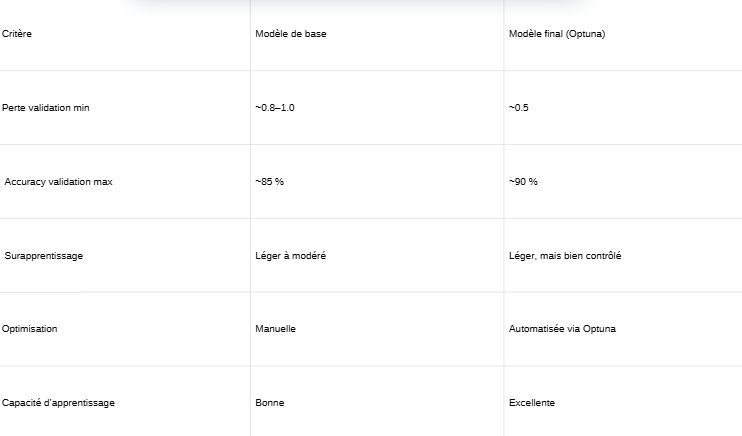